# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Rohan, Prajwal  
**Release date**: 05/03/21  
**Submission date** : 16/03/21

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
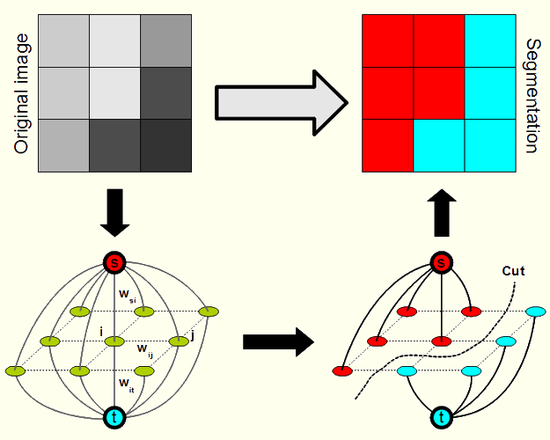

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [1]:
import numpy as np
import sys
import cv2
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import networkx as nx
import igraph as ig

In [2]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [3]:
def run(filename: str, grab_iters = 1, grab_comp=5, grab_gamma = 50, grab_conn=8):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}
    DRAW_SURE_BG = {'color' : COLORS['RED'], 'val' : 10}
    DRAW_SURE_FG = {'color' : COLORS['GREEN'], 'val' : 11}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img2 = img.copy()                                
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)           # output image to be shown
    final_mask = np.zeros(img.shape[:2], dtype = np.uint8)
    save_output = False
    
    #to store the images at each intermediate step
    iter_images = []
    output_images = []
    
    # Input and segmentation windows
    cv2.namedWindow('Input Image', cv2.WINDOW_GUI_NORMAL)
    cv2.namedWindow('Segmented Image', cv2.WINDOW_GUI_NORMAL)
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)

    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented Image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            print("Grab closing")
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_SURE_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_SURE_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            
            '''
            mask should be the area that corresponds to the foreground image
            use img2 for this since it's the clear undrawn image now. 
            '''
            print("Implementing Grab Cut ...")
            print("Bounding Box around:" , FLAGS["RECT"])
            print("Image shape: ", img2.shape, "\n")
                        
            gc = grab_cut(img2, mask, FLAGS["RECT"], DRAW_BG, DRAW_FG, DRAW_SURE_BG, DRAW_SURE_FG)
            final_mask, ims = gc.perform_grab_cut(iters = grab_iters, comp = grab_comp, gamma=grab_gamma, connectivity = grab_conn)
            
            iter_images.append(ims)
            print("Segmentation Done!")
            save_output = True
            
        EventObj.flags = FLAGS
        mask2 = np.where((final_mask == 1), 255, 0).astype('uint8')
        output = cv2.bitwise_and(img2, img2, mask = mask2) 
        
        if save_output:
            output_images.append(output)
            save_output = False
    
    return img, iter_images, output_images
    #plot_seg_results(img, iter_images, output_images)

In [4]:
def plot_seg_results(main_im, iter_images, output_images):
    
    print("Output images:",len(output_images), "\nImages per run", len(iter_images[0]))
    
    if not (len(output_images)==1 and len(iter_images[0])==1):
        
        for i in range(len(output_images)):
            
            fig, ax = plt.subplots(1,len(iter_images[i]), figsize=(15,8))
            
            for j, im in enumerate(iter_images[i]):
                ax[j].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
                ax[j].set_title("Out:"+str(i)+" Iter image: "+str(j))
    
        print()
        print()
        
    if len(output_images) > 0 :
        fig2, ax2 = plt.subplots(1, len(output_images)+1, figsize=(15,8))

        ax2[0].imshow(cv2.cvtColor(main_im, cv2.COLOR_BGR2RGB))
        for i, o in enumerate(output_images):

            ax2[i+1].imshow(cv2.cvtColor(o, cv2.COLOR_BGR2RGB))
            ax2[i+1].set_title("Out Image:"+str(i))
    else:
        print("Error!")
            
    #else:
        #plt.imshow(cv2.cvtColor(output_images[0], cv2.COLOR_BGR2RGB))
        #plt.title("Output Image : 0")
    
            

# Understanding GMM for Grabcut

The GMM or gaussian mixture model is an *unsupervised* algorithm that is used to cluster data points. The base assumption with GMM is that the different clusters (or subpopulations/components) that exist in the data have a **normal distribution**, ie. they are parameterized by a mean $\mu$ and a variance $\sigma$. 

A GMM learns the distribution of data points by trying to identify *k components* or *k* gaussian distributions for the given data. In order to estimate the parameters $\mu$ and $\sigma$ for the *k* components that our data points have, an expectation maximization approach is used. Mathematically, given $n$ points, each being $d$ dimension, the GMM estimates the parameters of the *k* gaussians by trying to maximze the probability of occurence of each of our data points. That is we wish to maximize (as log probability):

$$P(X|\pi, \mu ,\sigma) = \prod_{i=1}^{N} \sum_{k=1}^{K} (\pi_{k} . N(x_i | \mu_{k}, \sigma_{k}))$$
$$L = log(P(X|\pi, \mu ,\sigma)) = \sum_{i=1}^{N} log(\sum_{k=1}^{K} (\pi_{k} . N(x_i | \mu_{k}, \sigma_{k})))$$

This EM problem is an iterative procedure, where we start by initializing the normal dist parameters, then we compute the components for each data point (clusters to which the belong) and then recompute the vector of parameters ($\mu$, $\sigma$, $\pi$). The advantage with GMM over K-means clustering is that it is a soft clustering algorithm whereas kmeans is a hard clustering algorithm wherein a given sample is assigned to one and only one class. 

In **segmentation by Grabcut**, the entire image is represented as a gaussian mixture model. The GMM serves better as compared to a monochrome image model since constructing colour space histograms for all the colours in the image is impractical. There are ***two GMM models*** created in grabcut - 1) for the foreground pixel distribution and 2) for the background pixel distribution.The pixels belonging to the foreground and background are then assigned to one of the components from the bg or fg pixels respectively.

In [5]:
class GMM():
    
    def __init__(self, img, bg_ind, fg_ind, sure_bg_ind, sure_fg_ind, mask):
        
        self.img = np.asarray(img, dtype=np.float64)
        self.bg_ind = bg_ind
        self.fg_ind = fg_ind
        self.sure_bg_ind = sure_bg_ind
        self.sure_fg_ind = sure_fg_ind
        self.fg_unary_cost = np.empty(img.shape[:2])
        self.bg_unary_cost = np.empty(img.shape[:2])
        self.mask = mask
    
    '''
    Function to instantiate the GMM model
    for the proabable background and foreground
    '''
    def init_gmm(self, components=5):
        
        #fitting the background and probable foreground pixels to a GMM model
        self.bg_gmm = GaussianMixture(n_components = components, covariance_type='full', n_init = 1).fit(self.img[self.bg_ind])
        self.fg_gmm = GaussianMixture(n_components = components, covariance_type='full', n_init = 1).fit(self.img[self.fg_ind])
    
    '''
    Function to compute the unary costs for each pixel
    of it being connected to either the bg or the foreground
    Assigning a D value to each pixel based on the GMM model
    '''
    def assign_unary_cost(self, terminal, gmm_model):
            
        predictions = gmm_model.predict(self.img[self.fg_ind])
        sigma = gmm_model.covariances_
        mu = gmm_model.means_
        pi = gmm_model.weights_
        
        for i, pred in enumerate(predictions):
            
            x,y = self.fg_ind[0][i], self.fg_ind[1][i]
            
            t1 = -np.log(pi[pred])
            t2 = 0.5*np.log(np.linalg.det(sigma[pred]))           
            t3 = 0.5*( (self.img[x,y,:]-mu[pred]).T @ (np.linalg.inv(sigma[pred])) @ (self.img[x,y,:]-mu[pred]) )
            
            if terminal == "bg":
                self.bg_unary_cost[x,y] = (t1+t2+t3)
            elif terminal == "fg":
                self.fg_unary_cost[x,y] = (t1+t2+t3)
                
        if terminal == "bg":
            self.bg_unary_cost[self.bg_ind] = 1e12
            self.bg_unary_cost[self.sure_bg_ind] = 1e12
            self.bg_unary_cost[self.sure_fg_ind] = 0
                        
        elif terminal == "fg":
            self.fg_unary_cost[self.bg_ind] = 0
            self.fg_unary_cost[self.sure_bg_ind] = 0
            self.fg_unary_cost[self.sure_fg_ind] = 1e12


# Working of Grabcut

Grabcut is an iterative algorithm that works by constructing a graph from the image pixels and the GMMs of the background and foreground pixels. To start, the user marks a box containing the foreground pixels. This boxed region can also contain background pixels. Hence the entire image is divided into 3 parts - a) sure background, b) probable foreground, c) sure foreground. At the start of the iterations, the sure background pixels are {$\phi$}. The segmentation of the graph of pixels is done based on the **mincut** algorithm that aims at minimizing the cost of cutting edges in the graph of pixels that disconnects the foreground from the background. 

The cost (or energy) function for the mincut algorithm is defined over the edges of the graph. These edges account for two costs : 1) Unary cost **(U)** and 2) Binary or interpixel costs **(V)**. Mathematically this is represented as the *Gibbs Energy* for segmentation : 

$$E (\alpha, k, \theta, z) = U(\alpha, k, \theta, z) + V(\alpha, z)$$


### Step 1 : 
In the first step of Grabcut, the GMMs for the foreground and background pixels are initialised. Based on these models that are learnt, the **unary costs** for these pixels are assigned. While assigning the unary cost for the *fg pixels* the *bg GMM model* is used and vice versa for the *bg pixels*. This is because, the unary costs are assigned based on the **negative** of the *log likelihood*. Two terminal nodes, one for **fg terminal** and one for the **bg terminal** are added to the graph, and the unary costs are the capacities of the pixel-terminal edges to each of these terminals. A higher cost of an edge from a pixel to the fg terminal indicates that it's more likely to be an fg pixel. Unary costs are assigned as :

$$D(\alpha_n, k_n, \theta, z_n) = -log \pi(\alpha_n, k_n) + \frac{1}{2} log det \Sigma (\alpha_n, k_n) + \frac{1}{2}[z_n - \mu(\alpha_n, k_n)]^{T}\Sigma(\alpha_n, k_n)^{-1}[z_n - \mu(\alpha_n, k_n)]$$


### Step 2 :

In order to assign the binary costs, a neighbourhood of 8 connectivity or 4 connectivity is chosen where edges are added. The binary costs ensure that the neighbourhood and spatial effect is also factored in. The costs are assigned as :

$$V(\alpha, z) = \gamma \sum_{(m,n \in C)} exp(-\beta || z_m - z_n ||^{2})$$

The $\beta$ term relaxes the tendency to smoothness in regions of high contrast, ie: the edges are preserved. The $\gamma$ term is used to determine the degree of smoothness throughout the image. 

### Step 3 : 

Once the graph is prepared, the **mincut** algorithm is run on the graph of pixels. The result of the mincut is the mincut cost and the actual partition of the pixels (pixels $\in$ fg and pixels $\in$ bg). All the pixels that are connected to the fg terminal then are assigned an $\alpha$ value of 1 indicating that they are fg pixels while the remaining are 0.

### Step 4 : 

The last step is an optional user interaction wherein the user can scribble some pixels (that may be missed out by the algorithm) as foreground or background. These pixels will come under the **"sure"** category, and they will be for sure connected to their respective terminals. Further, these sure pixels will also impact the neighbourhood pixels and will add (or subtract) any missed out foreground (or background). The entire grab cut algorithm is run once again, after user interaction.



In [6]:
class grab_cut():
    
    def __init__(self, img, mask, rect, DRAW_BG, DRAW_FG, DRAW_SURE_BG, DRAW_SURE_FG, connectivity=8, gamma=50):
        
        self.img = np.asarray(img, dtype=np.float64)
        self.rows, self.cols, _ = img.shape
        self.DRAW_BG = DRAW_BG
        self.DRAW_FG = DRAW_FG
        self.DRAW_SURE_BG = DRAW_SURE_BG
        self.DRAW_SURE_FG = DRAW_SURE_FG
        self.conn = connectivity
        self.gamma = gamma
        self.rect = rect
        self.mask = mask
        
        self.img_h = self.img.shape[0]
        self.img_w = self.img.shape[1]
                    
        self.sure_bg_ind = np.where((self.mask == self.DRAW_SURE_BG['val']))            
        self.sure_fg_ind = np.where((self.mask == self.DRAW_SURE_FG['val']))
            
        #initializing the z_n: the foreground and background pixels. (0:x(TL), 1:y(TL), 2:x(BR), 3:y(BR)
        if rect is not None:
            self.mask[rect[1]:rect[1] + rect[3],rect[0]:rect[0] + rect[2]] = DRAW_FG['val']
        
        #place sure fg and bg colours
        self.mask[self.sure_bg_ind] = DRAW_SURE_BG['val']
        self.mask[self.sure_fg_ind] = DRAW_SURE_FG['val']
            
    
    def get_neighbours(self,p,q):
        
        neigh = []
        nsum = 0
        nsum2 =np.array([0.0,0.0,0.0])
        pmin = max(0, p-1)
        pmax = min(p+1+1, self.rows)
        
        qmin = max(0, q-1)
        qmax = min(q+1+1, self.cols)
        
        for i in range(pmin, pmax):
            for j in range(qmin, qmax):
                
                dis = 1
                #if (i==p and j==q) or (self.mask[i][j] == self.mask[p][q]):
                if (i==p and j==q):
                    continue
                    
                if (i==p-1 and j==q-1) or (i==p+1 and j==q+1) or (i==p-1 and j==q+1) or (i==p+1 and j==q-1):
                    if self.conn == 4:
                        continue
                    else:
                        dis = np.sqrt(2)
                    
                neigh.append((i,j,self.img[i,j,:],dis))
                diff = self.img[p,q,:]-self.img[i,j,:]
                nsum += np.dot(diff, diff)
                nsum2 += np.square(diff)
        

        return neigh, nsum, nsum2.mean()
                
                
    
    '''
    Function to compute the beta value for the 
    smoothness term to switch appropriately between
    low and high contrast areas.
    '''
    def compute_beta(self):
        
        beta_sum = 0
        beta_sum2 = 0
        neigh_count = 0
        for i in range(self.rows):
            for j in range(self.cols):
                
                neigh, nsum, nsum2 = self.get_neighbours(i,j)
                neigh_count += len(neigh)
                beta_sum += nsum
                beta_sum2 += nsum2
                
        beta = 1/(2*beta_sum/neigh_count)
        beta2 = 1/(2*beta_sum2/neigh_count)
        return beta, beta2
    
    '''
    Function to prepare the graph with the unary costs
    and create edges with the binary cost terms (V)
    '''
    def prepare_graph(self):
        
        #self.G = nx.Graph()
        #self.G.add_node("bg")
        #self.G.add_node("fg")
        
        self.G = ig.Graph()
        self.G.add_vertices( self.img_h * self.img_w + 2)   #0 based indexing, so require w*h + 2 st nodes
        self.FG_SOURCE = self.img_h * self.img_w            #Source node is the w*h node
        self.BG_SINK = self.img_h * self.img_w + 1          #sink node is the w*h + 1 node
        
        edges = []
        self.capacities = []
        
        print("Building segmentation graph ...")
        
        #adding unary cost edges      
        for i in range(self.rows):
            for j in range(self.cols):
                
                #self.G.add_node((i,j))
                #self.G.add_edge("fg", (i,j), capacity=self.gmm.fg_unary_cost[i][j])
                #self.G.add_edge((i,j), "bg", capacity=self.gmm.bg_unary_cost[i][j])
                ver = self.img_w * i + j
                edges.append((self.FG_SOURCE, ver))
                edges.append((ver, self.BG_SINK))
                self.capacities.append(self.gmm.fg_unary_cost[i][j])
                self.capacities.append(self.gmm.bg_unary_cost[i][j])
                

        #nx.draw(self.G) 
        #print("GMM costs")
        #print(self.gmm.fg_unary_cost.shape, self.gmm.fg_unary_cost[self.fg_ind])
        #print(self.gmm.bg_unary_cost.shape, self.gmm.bg_unary_cost[self.fg_ind])
        
        self.beta, self.beta2 = self.compute_beta()
        
        #adding binary cost edges
        for i in range(self.rows):
            for j in range(self.cols):
                
                neigh, _, _, = self.get_neighbours(i,j)
                for n in neigh:
                    diff = self.img[i,j,:]-self.img[n[0],n[1],:]
                    cap = self.gamma * np.exp(-self.beta2 * np.dot(diff, diff))
                    #self.G.add_node((n[0], n[1]))
                    #self.G.add_edge((i,j), (n[0], n[1]), capacity = cap)
                    ver1 = self.img_w * i + j
                    ver2 = self.img_w * n[0] + n[1]
                    edges.append((ver1, ver2))
                    self.capacities.append(cap)
        
        self.G.add_edges(edges)                    
        print("Graph prepared, starting segmentation ...")
    
    def estimate_segmentation(self):
        
        mincut = self.G.st_mincut( self.FG_SOURCE, self.BG_SINK, self.capacities)
        print("Mincut cost = ", mincut.value)
        print("*************************************")
        
        #cut_value, partition = nx.minimum_cut(self.G, 'fg', 'bg')
        #reachable, non_reachable = partition
        alphas = np.zeros((self.img.shape[0], self.img.shape[1]))

        #for px in reachable:
        for px in mincut.partition[0]:
            if px != self.FG_SOURCE:
                #alphas[px[0]][px[1]] = 1
                try:
                    alphas[px//self.img_w][px%self.img_w] = 1
                except:
                    print("px", px)
                    print("hw", self.img_h, self.img_w)
                    print(px//self.img_h, px%self.img_h)
                    return 0
                
        #placing sure pixel masks
        alphas[self.sure_bg_ind] = 10
        alphas[self.sure_fg_ind] = 11
        
        return alphas, mincut.value
    
    def get_image(self):
        
        m = self.mask.copy()
        m[self.sure_bg_ind] = 0
        m[self.sure_fg_ind] = 1
        
        m2 = np.where((m == 1), 255, 0).astype('uint8')
        out_img = cv2.bitwise_and(self.img.astype('uint8'), self.img.astype('uint8'), mask = m2) 
        return out_img
        
        
    def perform_grab_cut(self, iters=1, comp = 5, gamma=50, connectivity=8):
        
        self.gamma = gamma
        self.comp = comp
        self.connectivity = connectivity
        final_mask = np.empty(self.img.shape[:2])
        iter_images = []
        mincut_val = 1e12
        THRESH = 30000
        
        for it in range(iters):
            print("iter ===== ", it)
            
            self.bg_ind = np.where((self.mask == self.DRAW_BG['val']) | (self.mask == self.DRAW_SURE_BG['val']))
            self.fg_ind = np.where((self.mask == self.DRAW_FG['val']) | (self.mask == self.DRAW_SURE_FG['val'])) 
            
            #print("Sure bg and fg indices = ", len(self.sure_bg_ind[0]), len(self.sure_fg_ind[0]))
            #print("Remaining indc bg and fg indices = ", len(self.bg_ind[0]), len(self.fg_ind[0]))
            
            self.gmm = GMM(self.img, self.bg_ind, self.fg_ind, self.sure_bg_ind, self.sure_fg_ind, self.mask)
            print("self.comp", self.comp)
            self.gmm.init_gmm(self.comp)
            
            self.gmm.assign_unary_cost("bg", self.gmm.fg_gmm)
            self.gmm.assign_unary_cost("fg", self.gmm.bg_gmm)
                
            self.prepare_graph()
            self.mask, mv = self.estimate_segmentation()  
            print("Segmentation Done for iter ", it)
            
            iter_images.append(self.get_image())
            
            #checking convergence
            if abs(mv - mincut_val) <= THRESH:
                print("mincut converged")
                break
                
            mincut_val = mv
            
  
        #changing sure pixel masks back to 0,1
        self.mask[self.sure_bg_ind] = 0
        self.mask[self.sure_fg_ind] = 1
        
        return self.mask, iter_images

# Performing Grab Cut

## Image : Llama in a desert

In [24]:
filename = '../images/llama.jpg'               # Path to image file
llama_img, llama_iter_im, llama_out_im = run(filename, 5)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (119, 102, 246, 285)
Image shape:  (371, 513, 3) 

iter =====  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  651002.065389497
*************************************
Segmentation Done for iter  0
iter =====  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  298966.04281647265
*************************************
Segmentation Done for iter  1
iter =====  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  296785.651882456
*************************************
Segmentation Done for iter  2
mincut converged
Segmentation Done!
Grab closing


Output images: 1 
Images per run 3




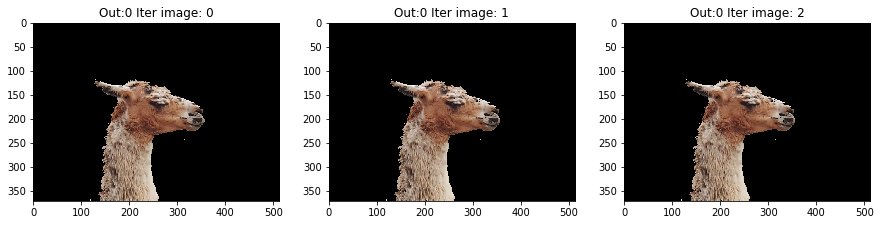

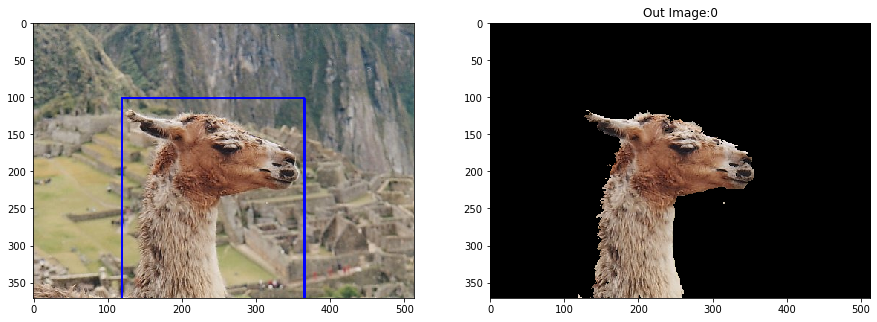

In [25]:
plot_seg_results(llama_img, llama_iter_im, llama_out_im)

## Image : Pink Doll

In [28]:
filename = '../images/doll.jpg'               # Path to image file
doll_img, doll_iter_im, doll_out_im = run(filename, 5)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (16, 18, 385, 525)
Image shape:  (549, 462, 3) 

iter =====  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1947871.8634049809
*************************************
Segmentation Done for iter  0
iter =====  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1091031.6462277318
*************************************
Segmentation Done for iter  1
iter =====  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1071936.6303602103
*************************************
Segmentation Done for iter  2
mincut converged
Segmentation Done!
Implementing Grab Cut ...
Bounding Box around: (16, 18, 385, 525)
Image shape:  (549, 462, 3) 

iter =====  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1923076.8406665737
*************************************
Segmentation Done for iter  0
iter =====  

Output images: 2 
Images per run 3




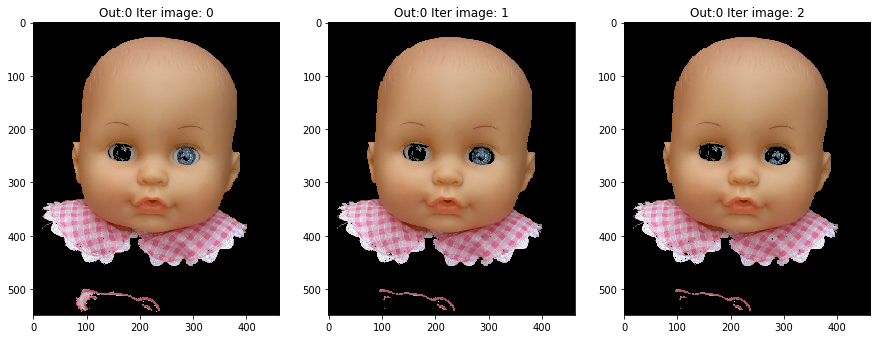

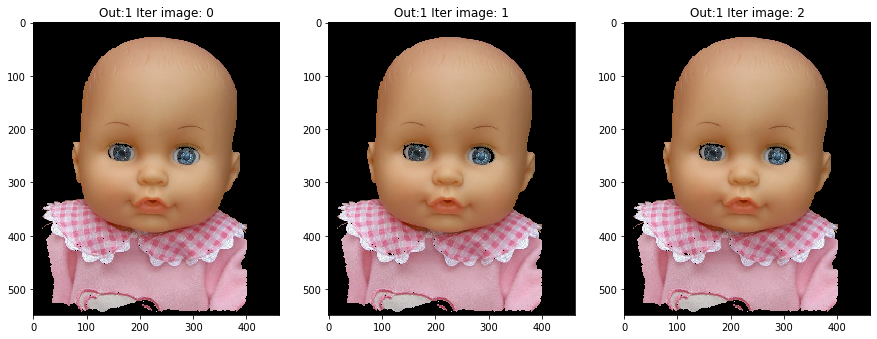

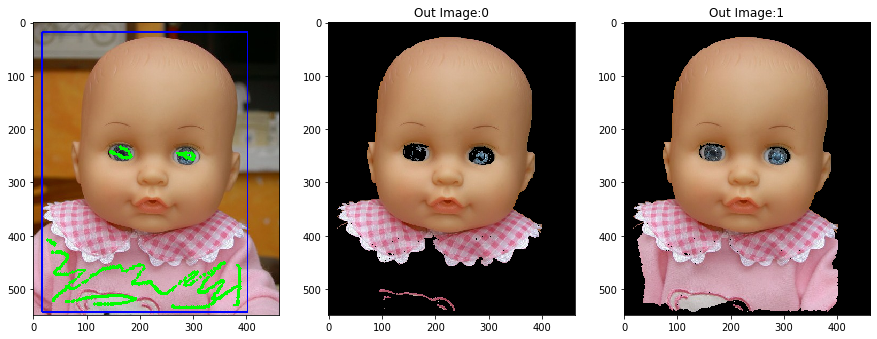

In [31]:
plot_seg_results(doll_img, doll_iter_im, doll_out_im)

## Image : Banana Yellow

In [19]:
filename = '../images/banana1.jpg'               # Path to image file
banana1_img, banana1_iter_im, banana1_out_im = run(filename, 5)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (24, 24, 584, 406)
Image shape:  (480, 640, 3) 

iter =====  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1995062.3960502686
*************************************
Segmentation Done for iter  0
iter =====  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1531268.3865887085
*************************************
Segmentation Done for iter  1
iter =====  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1413950.1404690295
*************************************
Segmentation Done for iter  2
iter =====  3
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1392717.8195150814
*************************************
Segmentation Done for iter  3
iter =====  4
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1385285.8022828272
**********************

Output images: 2 
Images per run 5




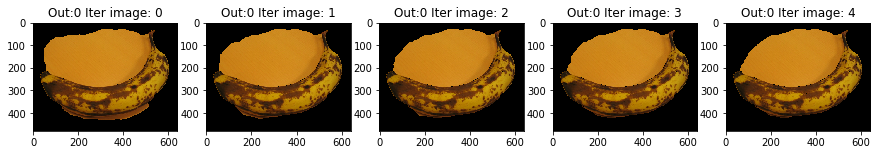

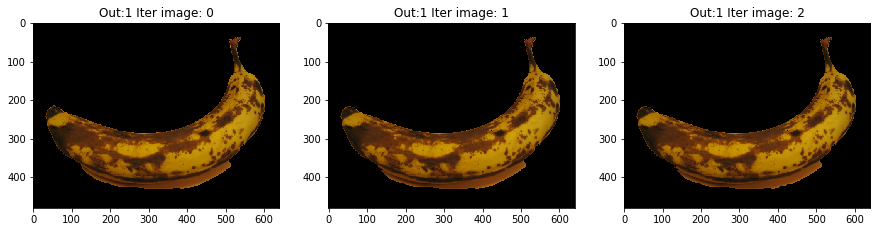

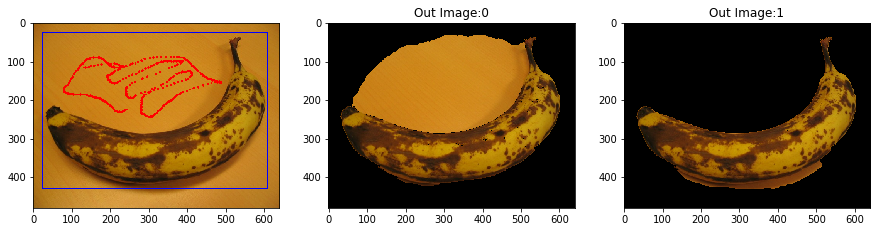

In [34]:
plot_seg_results(banana1_img, banana1_iter_im, banana1_out_im)

## Image : Banana Rose

In [37]:
filename = '../images/banana3.jpg'               # Path to image file
banana3_img, banana3_iter_im, banana3_out_im = run(filename, 5)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (25, 67, 608, 350)
Image shape:  (480, 640, 3) 

iter =====  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  2384843.076966853
*************************************
Segmentation Done for iter  0
iter =====  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1631443.133592408
*************************************
Segmentation Done for iter  1
iter =====  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1171099.5371539746
*************************************
Segmentation Done for iter  2
iter =====  3
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1064853.7195300683
*************************************
Segmentation Done for iter  3
iter =====  4
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1051661.8188538696
************************

Output images: 2 
Images per run 5




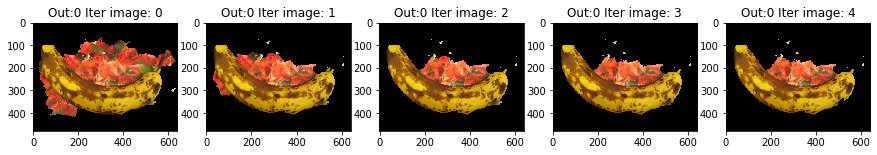

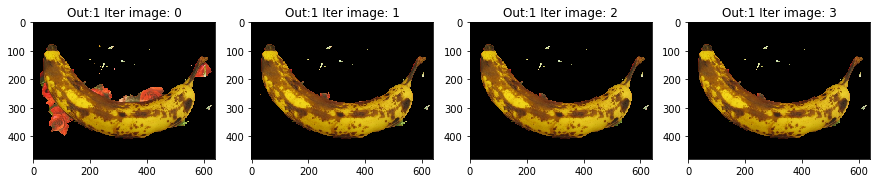

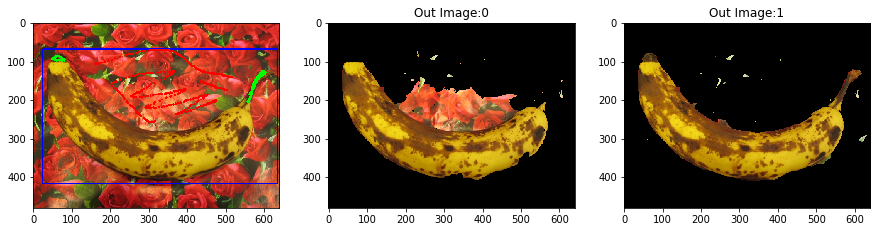

In [38]:
plot_seg_results(banana3_img, banana3_iter_im, banana3_out_im)

## Image : Stone Rock

In [40]:
filename = '../images/stone1.jpg'               # Path to image file
stone1_img, stone1_iter_im, ston1_out_im = run(filename, 5)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (217, 44, 259, 397)
Image shape:  (480, 640, 3) 

iter =====  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  767876.6887250204
*************************************
Segmentation Done for iter  0
iter =====  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  451646.4879137955
*************************************
Segmentation Done for iter  1
iter =====  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  445109.24348307174
*************************************
Segmentation Done for iter  2
mincut converged
Segmentation Done!
Grab closing


Output images: 1 
Images per run 3




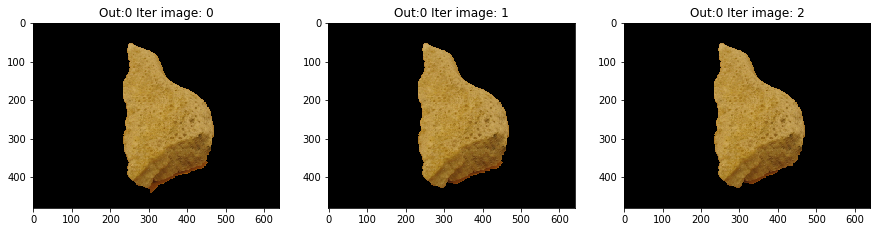

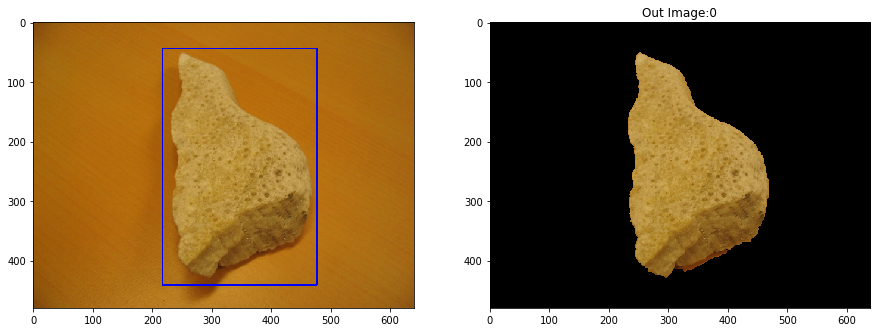

In [41]:
plot_seg_results(stone1_img, stone1_iter_im, ston1_out_im)

## Image : Reading Person

In [43]:
filename = '../images/person6.jpg'               # Path to image file
per6_img, per6_iter_im, per6_out_im = run(filename, 5)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (137, 119, 165, 404)
Image shape:  (600, 450, 3) 

iter =====  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  642340.7408642799
*************************************
Segmentation Done for iter  0
iter =====  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  318542.8187088189
*************************************
Segmentation Done for iter  1
iter =====  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  299182.9889723327
*************************************
Segmentation Done for iter  2
mincut converged
Segmentation Done!
Implementing Grab Cut ...
Bounding Box around: (137, 119, 165, 404)
Image shape:  (600, 450, 3) 

iter =====  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  625005.0215713505
*************************************
Segmentation Done for iter  0
iter =====  

Output images: 2 
Images per run 3




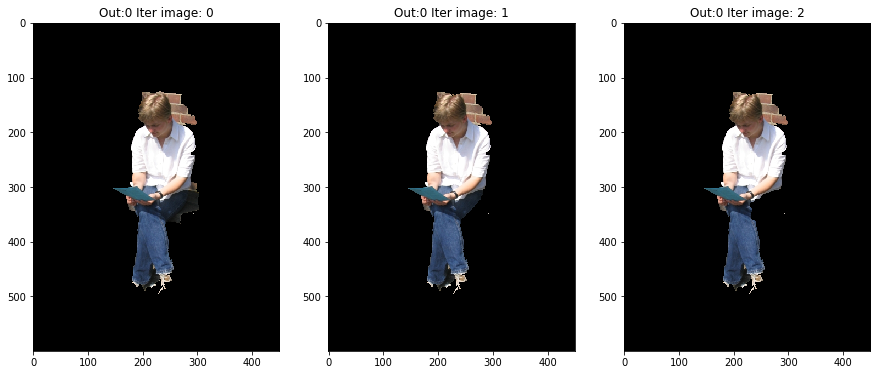

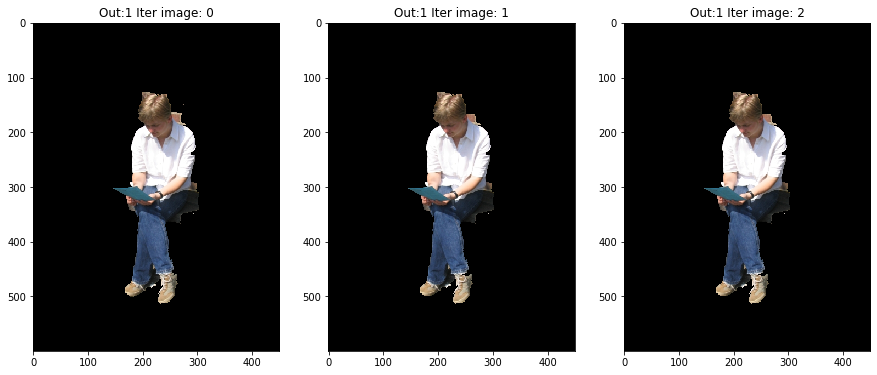

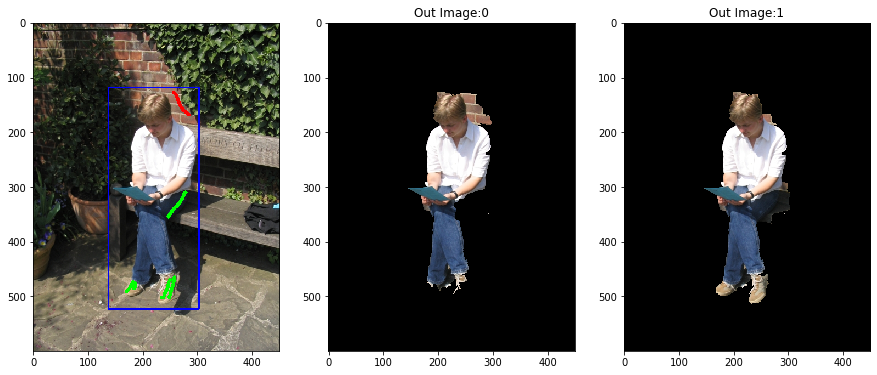

In [44]:
plot_seg_results(per6_img, per6_iter_im, per6_out_im)

## Image: Memorial Shield

In [46]:
filename = '../images/memorial.jpg'               # Path to image file
memorial_im, memorial_iter_im, memorial_out_im = run(filename, 5)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (78, 152, 262, 346)
Image shape:  (600, 450, 3) 

iter =====  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  824670.7447736774
*************************************
Segmentation Done for iter  0
iter =====  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  421925.84827724734
*************************************
Segmentation Done for iter  1
iter =====  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  377751.95932211407
*************************************
Segmentation Done for iter  2
iter =====  3
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  375683.11716385675
*************************************
Segmentation Done for iter  3
mincut converged
Segmentation Done!
Implementing Grab Cut ...
Bounding Box around: (78, 152, 262, 346)
Image shape:  (600, 450, 3) 

iter ===== 

Output images: 2 
Images per run 4




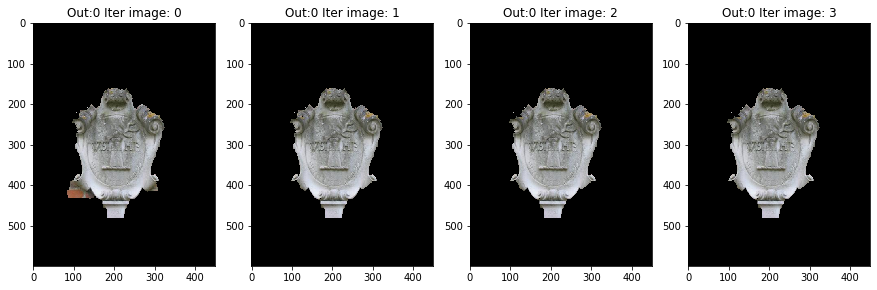

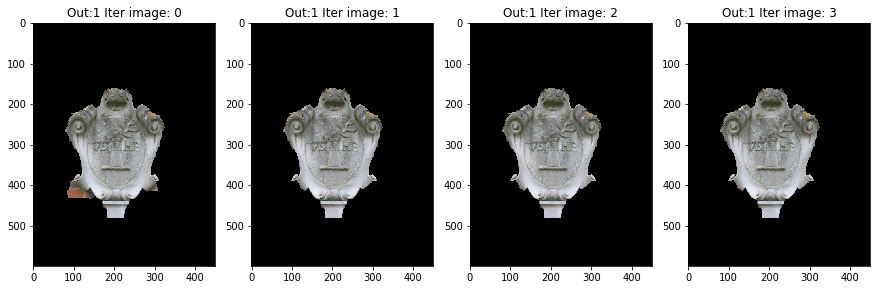

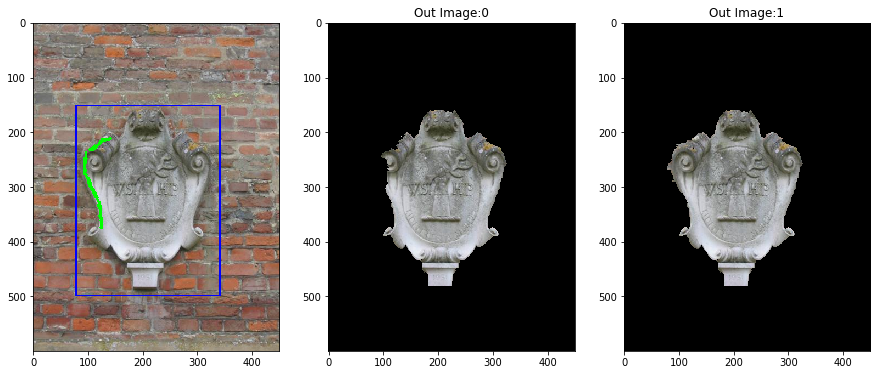

In [47]:
plot_seg_results(memorial_im, memorial_iter_im, memorial_out_im)

# -------------------------------------------------------------------------------------------------------

# Report and Analysis

The following section includes a report about the study of how changes in the various parameters affects the segmentation of an image. These are the hyperparameters that are tuned by experiments and observations. The hyperparameters that explored an explained in this section are as follows : 

1. Number of GMM components

2. Choice of Gamma

3. Bounding box analysis : a) Size b) Other uses

In [8]:
filename = '../images/bush.jpg'               # Path to image file
bush_im_comp2, bush_iter_im_comp2, bush_out_im_comp2 = run(filename, 5, 2)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (123, 53, 216, 489)
Image shape:  (600, 450, 3) 

iter =====  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1255933.3126742751
*************************************
Segmentation Done for iter  0
iter =====  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  477452.1588298375
*************************************
Segmentation Done for iter  1
iter =====  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  464848.4292555129
*************************************
Segmentation Done for iter  2
mincut converged
Segmentation Done!
Grab closing


Output images: 1 
Images per run 3




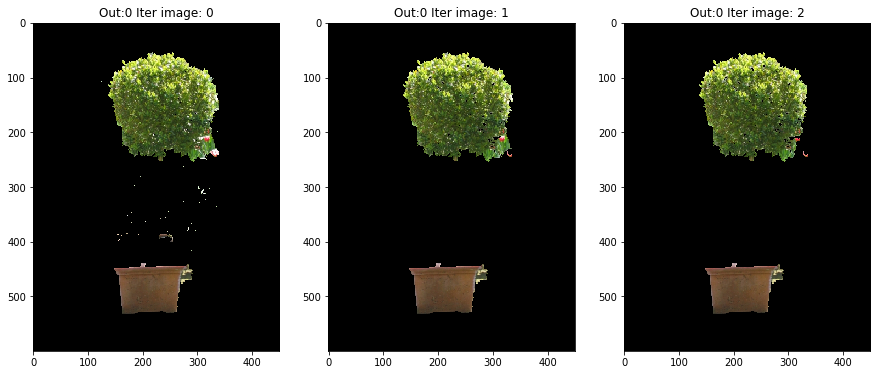

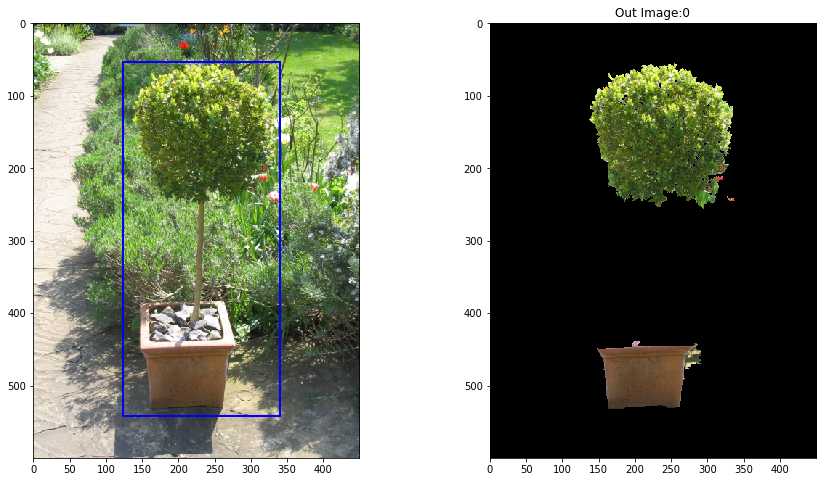

In [9]:
plot_seg_results(bush_im_comp2, bush_iter_im_comp2, bush_out_im_comp2)

In [10]:
filename = '../images/bush.jpg'               # Path to image file
bush_im_comp10, bush_iter_im_comp10, bush_out_im_comp10 = run(filename, 5, 10)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (114, 52, 225, 491)
Image shape:  (600, 450, 3) 

iter =====  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1276029.5383957783
*************************************
Segmentation Done for iter  0
iter =====  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  816188.6400167547
*************************************
Segmentation Done for iter  1
iter =====  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  738856.8469763052
*************************************
Segmentation Done for iter  2
iter =====  3
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  709377.817702543
*************************************
Segmentation Done for iter  3
mincut converged
Segmentation Done!
Grab closing


Output images: 1 
Images per run 4




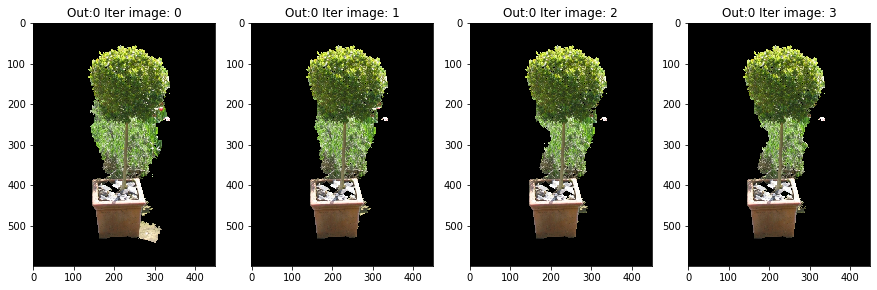

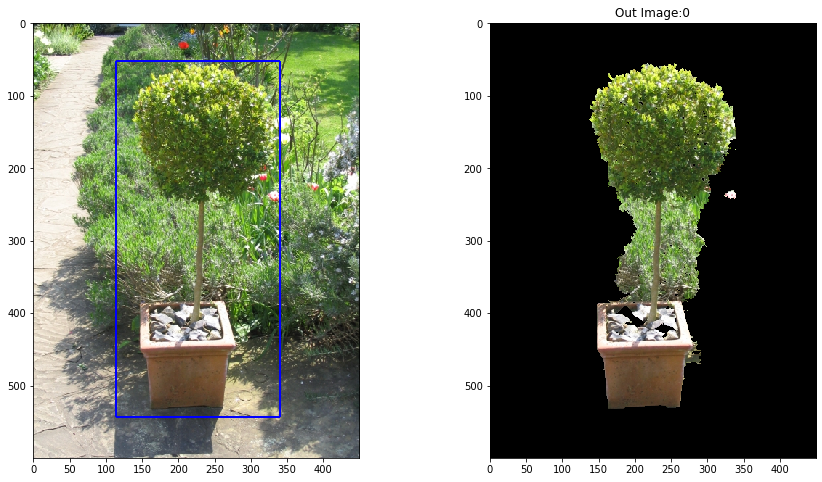

In [25]:
plot_seg_results(bush_im_comp10, bush_iter_im_comp10, bush_out_im_comp10)

## 1. Analysis of Num GMM Components

The number of GMM components that are specified while initializing the GMM model are indicative of the number of possible colour that are contained within the background and foreground. The model tries to assign the pixels into the *k components* that are used to define the GMM. 

We observe that with *more number of components*, there is a better distribution of pixels into the differnet compoennts, since there exist more number of gaussian distributions that a pixel could probably blong to. Like as we see in the images below, the stem of the bush is not identified as a foreground pixel in the case when *only 2* components are used to define the GMM. 

However, the performance of the GMM for image segmentation does not keep increasing with increase in the number of components. As we see in the second image, a lot of background pixels have been included in the foreground segmentation as well. There exists a middle ground value that is ideal for the segmentation and for modelling the foreground and background pixel distributions. 

Text(0.5, 1.0, 'Segmentation with 10 comp')

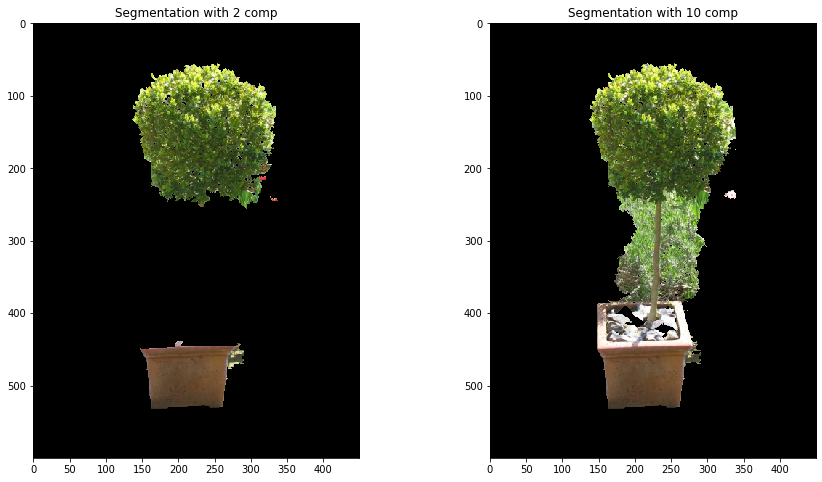

In [29]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(cv2.cvtColor(bush_out_im_comp2[0], cv2.COLOR_BGR2RGB))
ax[0].set_title("Segmentation with 2 comp")

ax[1].imshow(cv2.cvtColor(bush_out_im_comp10[0], cv2.COLOR_BGR2RGB))
ax[1].set_title("Segmentation with 10 comp")

In [48]:
filename = '../images/ceramic.jpg'               # Path to image file
ceramic_im_comp2, ceramic_iter_im_comp2, ceramic_out_im_comp2 = run(filename, 5, 1)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (107, 27, 469, 413)
Image shape:  (480, 640, 3) 

iter =====  0
self.comp 1
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1930570.380430695
*************************************
Segmentation Done for iter  0
iter =====  1
self.comp 1
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1216048.1849406702
*************************************
Segmentation Done for iter  1
iter =====  2
self.comp 1
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1206060.2864899384
*************************************
Segmentation Done for iter  2
mincut converged
Segmentation Done!
Grab closing


In [49]:
filename = '../images/ceramic.jpg'               # Path to image file
ceramic_im_comp10, ceramic_iter_im_comp10, ceramic_out_im_comp10 = run(filename, 5, 10)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (100, 28, 460, 407)
Image shape:  (480, 640, 3) 

iter =====  0
self.comp 10
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1760130.7983945014
*************************************
Segmentation Done for iter  0
iter =====  1
self.comp 10
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1059692.3333584245
*************************************
Segmentation Done for iter  1
iter =====  2
self.comp 10
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1019001.130318911
*************************************
Segmentation Done for iter  2
iter =====  3
self.comp 10
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1009551.276442795
*************************************
Segmentation Done for iter  3
mincut converged
Segmentation Done!
Grab closing


Text(0.5, 1.0, 'Segmentation with 10 comp')

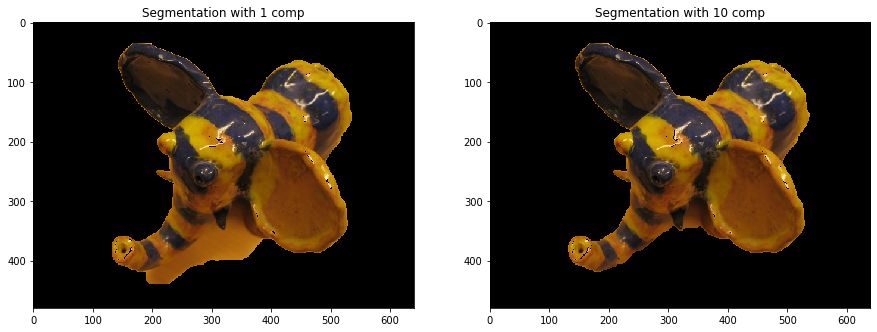

In [50]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(cv2.cvtColor(ceramic_out_im_comp2[0], cv2.COLOR_BGR2RGB))
ax[0].set_title("Segmentation with 1 comp")

ax[1].imshow(cv2.cvtColor(ceramic_out_im_comp10[0], cv2.COLOR_BGR2RGB))
ax[1].set_title("Segmentation with 10 comp")

## 2. Analysis of Gamma 

The $\gamma$ parameter that is a part of the smoothness term in the Gibbs energy equation decides the degree to which the image is smoothened. This smoothness is required between regions of low contrast and high contrast, since generally images have nature of being continuous and hence there must be a gradual transition in portions of the image that are not edges. The following images show the effect of tweaking this hyperparameter $\gamma$

In [61]:
filename = '../images/person3.jpg'               # Path to image file
person3_im_gamma1, person3_iter_im_gamma1, person3_out_im_gamma1 = run(filename, 5, 5, 1)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (124, 184, 208, 376)
Image shape:  (600, 450, 3) 

iter =====  0
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  662124.7582040278
*************************************
Segmentation Done for iter  0
iter =====  1
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  523442.42075400613
*************************************
Segmentation Done for iter  1
iter =====  2
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  423323.6989672361
*************************************
Segmentation Done for iter  2
iter =====  3
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  382714.1738666822
*************************************
Segmentation Done for iter  3
iter =====  4
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation .

In [63]:
filename = '../images/person3.jpg'               # Path to image file
person3_im_gamma50, person3_iter_im_gamma50, person3_out_im_gamma50 = run(filename, 5, 5, 50)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (134, 200, 200, 360)
Image shape:  (600, 450, 3) 

iter =====  0
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  650718.443076966
*************************************
Segmentation Done for iter  0
iter =====  1
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  293236.0153978269
*************************************
Segmentation Done for iter  1
iter =====  2
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  256037.0561165489
*************************************
Segmentation Done for iter  2
iter =====  3
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  248672.28259588106
*************************************
Segmentation Done for iter  3
mincut converged
Segmentation Done!
Grab closing


In [65]:
filename = '../images/person3.jpg'               # Path to image file
person3_im_gamma250, person3_iter_im_gamma250, person3_out_im_gamma250 = run(filename, 5, 5, 250)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (134, 196, 212, 364)
Image shape:  (600, 450, 3) 

iter =====  0
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  784756.6073275757
*************************************
Segmentation Done for iter  0
iter =====  1
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  279569.90971857775
*************************************
Segmentation Done for iter  1
iter =====  2
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  282298.3239555886
*************************************
Segmentation Done for iter  2
mincut converged
Segmentation Done!
Grab closing


Text(0.5, 1.0, 'Segmentation with gamma 250')

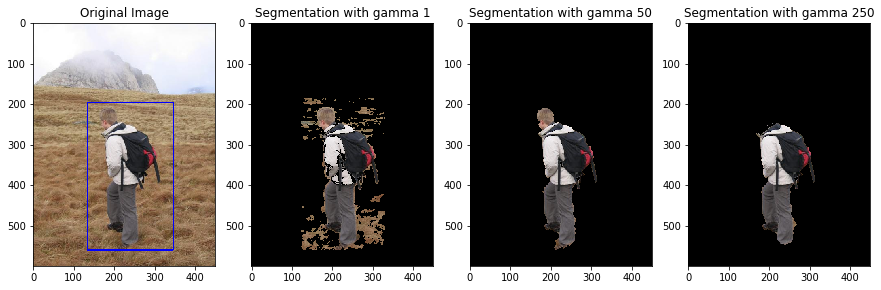

In [70]:
fig, ax = plt.subplots(1,4,figsize=(15,8))
ax[0].imshow(cv2.cvtColor(person3_im_gamma250, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")

ax[1].imshow(cv2.cvtColor(person3_out_im_gamma1[0], cv2.COLOR_BGR2RGB))
ax[1].set_title("Segmentation with gamma 1")

ax[2].imshow(cv2.cvtColor(person3_out_im_gamma50[0], cv2.COLOR_BGR2RGB))
ax[2].set_title("Segmentation with gamma 50")

ax[3].imshow(cv2.cvtColor(person3_out_im_gamma250[0], cv2.COLOR_BGR2RGB))
ax[3].set_title("Segmentation with gamma 250")

### Observations 

As we see that the value of $\gamma$ plays a critical role in assigning the interpixel weights to the edges in the graph of pixels. For a **very low** value of $\gamma$, the segmentation leaves in some of the pixels that do not belong to the foreground. As we can see some of the grass still remains in the image. While a **very high** value of $\gamma$ causes some of the foreground itself to get removed, since in the case that the foreground and background pixels are of same colour and intensity, a high $\gamma$ implies a higher edge cost. Therefore we see that the trekkers head is erased with a very high $\gamma$. 

An ideal middle-ground value of $\gamma$ should be chosen, as suggested by the paper. A value of 50 gives the most promising result for this segmentation.

## 3. Bounding Box 

The novelty proposed in the grabcut implementation lies in the convenient and minimalistic UI that it proposes for image segmentation. The bounding box is to be drawn around the foreground region that is to be segmented out. Two factors of the bounding box are analysed below namely a) fit of the box, b) improvements to box for segmentation

In [7]:
filename = '../images/grave.jpg'               # Path to image file
grave_im_loose, grave_iter_im_loose, grave_out_im_loose = run(filename, 5)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (17, 51, 415, 484)
Image shape:  (600, 450, 3) 

iter =====  0
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1770736.8044181895
*************************************
Segmentation Done for iter  0
iter =====  1
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  745777.6394996697
*************************************
Segmentation Done for iter  1
iter =====  2
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  687726.1672119056
*************************************
Segmentation Done for iter  2
iter =====  3
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  688207.9967232951
*************************************
Segmentation Done for iter  3
mincut converged
Segmentation Done!
Grab closing


In [8]:
filename = '../images/grave.jpg'               # Path to image file
grave_im_tight, grave_iter_im_tight, grave_out_im_tight = run(filename, 5)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (166, 156, 172, 299)
Image shape:  (600, 450, 3) 

iter =====  0
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  461744.143644796
*************************************
Segmentation Done for iter  0
iter =====  1
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  285133.5237900573
*************************************
Segmentation Done for iter  1
iter =====  2
self.comp 5
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  267361.77290628635
*************************************
Segmentation Done for iter  2
mincut converged
Segmentation Done!
Grab closing


Text(0.5, 1.0, 'Segmentation with tight bounding box')

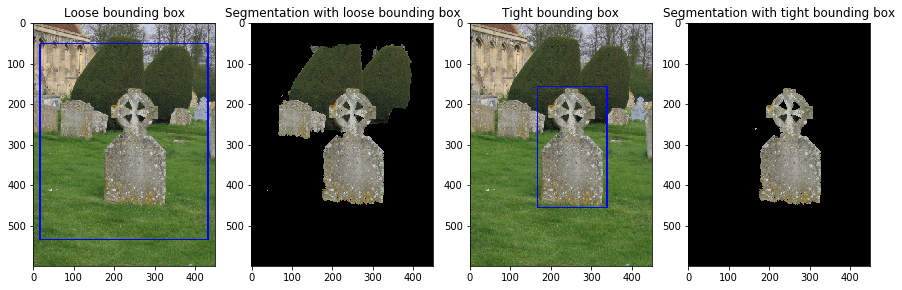

In [9]:
fig, ax = plt.subplots(1,4,figsize=(15,8))
ax[0].imshow(cv2.cvtColor(grave_im_loose, cv2.COLOR_BGR2RGB))
ax[0].set_title("Loose bounding box")

ax[1].imshow(cv2.cvtColor(grave_out_im_loose[0], cv2.COLOR_BGR2RGB))
ax[1].set_title("Segmentation with loose bounding box")

ax[2].imshow(cv2.cvtColor(grave_im_tight, cv2.COLOR_BGR2RGB))
ax[2].set_title("Tight bounding box")

ax[3].imshow(cv2.cvtColor(grave_out_im_tight[0], cv2.COLOR_BGR2RGB))
ax[3].set_title("Segmentation with tight bounding box")

### Observations

a) Starting off with a loose or a tight initial bounding box can affect the segmentation of the image. This is because a looser bounding box would mean, more amound of background pixels are incorporated into the $T_U$ region and hence the GMM model will be trained on a lot of bg pixels as well. This may result in bad segmentation results. While a tighter bounding box ensures that the foreground GMM model is as close to the distribution of colours in the foreground pixels and that the GMM models the foreground pixels as accurately as possible. 

b) Further, a few proposals to use bounding boxes for segmentation can be to incorporate flexible shapes for the bounding box. That is the user can specify the bounding box coordinates via the UI and the figure need not be a concave polygon in this case. This can ensure that the box is a tighter fit on the foreground object. Another option could be to integrate the magic wand tool for this GMM based grab cut segmentation. This will inturn provide an even tighter bound to the foreground pixels.

## 4. Iterations of GMM update and Energy minimization

With increased iterations of GMM update and energy minimization, the segmentation gets better and better. As we observe in the llama image, the segmentation gets better from the 1st to the 2nd image by omitting some of the background pixels. 

This is because, with each iteration, the $\alpha$ values are assigned to each pixel, marking them as either fg or bg, and in every iteration the GMM model for the fg and bg is learnt for the fg and bg pixels for that iteration. As a result, the models in successive iterations will learn GMMs that have more specific fg pixels than bg pixels and hence result in better segmentation.

However, once again, this isn't a monotonically increasing function as at some point the algorithm converges. This convergence is achieved either when the difference in the mincut values between two successive iterations is < a THRESH or this algorithm is found to empirically converge after around 5-6 iterations.